# Experiments on Tuning

A note on dependencies: this noteobok requires PyMC3 version from GitHub (at least at the time of writing): at least from [this commit](https://github.com/pymc-devs/pymc3/commit/c412736fc6861bba2c6530ec11ffe03b6629df2a) onwards.

In [1]:
%load_ext nb_black

import time
import logging
import pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from pymc3.step_methods.hmc.quadpotential import (
    QuadPotentialDiagAdapt,
    QuadPotentialFullAdapt,
)
from pymc3.sampling import init_nuts
import theano.tensor as tt
import arviz as az
import covadapt

sns.set_style("darkgrid")
logging.getLogger("pymc3").setLevel(logging.CRITICAL)

<IPython.core.display.Javascript object>

## Benchmarking functions

In [2]:
def benchmark_once(model, potential, tune=1000, draws=1000):
    """ Benchmark one pm.Model against one potential.
    
    Notes
    -----
    It is necessary to set `cores=1` to get the mass matrix in the step object.
    """
    with model:
        step = pm.NUTS(potential=potential, target_accept=0.9)
        t0 = time.time()
        tuning_trace = pm.sample(
            tune=tune,
            draws=0,
            chains=1,
            cores=1,
            step=step,
            compute_convergence_checks=False,
            discard_tuned_samples=False,
            random_seed=42,
        )
        t1 = time.time()
        # Following line only works with chains = 1...
        start = [t[-1] for t in tuning_trace._straces.values()]
        t2 = time.time()
        trace = pm.sample(
            tune=0,
            draws=draws,
            chains=1,
            cores=1,
            step=step,
            start=start,
            compute_convergence_checks=False,
            random_seed=42,
        )
        t3 = time.time()

    tuning_time = t1 - t0
    effective_samples_per_second = az.ess(az.from_pymc3(trace)) / (t3 - t2)
    effective_samples_per_second = [
        data_var.values for data_var in effective_samples_per_second.data_vars.values()
    ]

    return tuning_time, effective_samples_per_second

<IPython.core.display.Javascript object>

In [3]:
def benchmark_loops(model, potential_lambda, tune, draws, num_loops):
    tuning_times = []
    effective_samples_per_second = []

    for _ in range(num_loops):
        potential = potential_lambda()  # Instantiate a new potential object each time
        tuning_time_, effective_samples_per_second_ = benchmark_once(
            model, potential, tune, draws
        )
        tuning_times.append(tuning_time_)
        effective_samples_per_second.append(effective_samples_per_second_)

    return tuning_times, effective_samples_per_second

<IPython.core.display.Javascript object>

In [4]:
def benchmark(
    model, model_name, benchmark_covadapt=False, tune=2000, draws=1000, num_loops=1
):
    potentials = {
        "diag": lambda: QuadPotentialDiagAdapt(
            n=model.ndim, initial_mean=np.zeros(model.ndim)
        ),
        "full": lambda: QuadPotentialFullAdapt(
            n=model.ndim, initial_mean=np.zeros(model.ndim)
        ),
        "diag_expanding": lambda: QuadPotentialDiagAdapt(
            n=model.ndim,
            initial_mean=np.zeros(model.ndim),
            adaptation_window=100,
            adaptation_window_multiplier=1.005,
        ),
        "full_expanding": lambda: QuadPotentialFullAdapt(
            n=model.ndim,
            initial_mean=np.zeros(model.ndim),
            adaptation_window=100,
            adaptation_window_multiplier=1.005,
        ),
    }

    if benchmark_covadapt:
        potentials = {
            "covadapt": lambda: covadapt.EigvalsAdapt(
                model.ndim,
                np.zeros(model.ndim),
                estimators=[
                    lambda samples, grads: covadapt.eigh_lw_samples_grads(
                        samples, grads, n_eigs=20, n_eigs_grad=20, n_final=40
                    )
                ],
                display=True,
            )
        }

    tuning_times = {}
    effective_samples_per_second = {}

    for name, potential_lambda in potentials.items():
        print(name)
        tuning_times_, effective_samples_per_second_ = benchmark_loops(
            model, potential_lambda, tune, draws, num_loops
        )
        tuning_times[name] = tuning_times_
        effective_samples_per_second[name] = effective_samples_per_second_

    with open(f"{model_name}.json", "w+") as f:
        json.dump(
            {
                "tuning_times": tuning_times,
                "effective_samples_per_second": {
                    key: [list(np.hstack(a)) for a in value]
                    for key, value in effective_samples_per_second.items()
                },
            },
            f,
        )

    return tuning_times, effective_samples_per_second

<IPython.core.display.Javascript object>

In [5]:
def compare_benchmark_results(tuning_times, effective_samples_per_second):
    print("Mean tuning times:")
    print(
        pd.DataFrame().from_dict(
            {key: [np.mean(value)] for key, value in tuning_times.items()}
        )
    )

    print("")
    print("Mean effective samples per second:")

    mean_effective_samples_per_second = {
        key: [np.mean(np.vstack([np.hstack(foo) for foo in value]))]
        for key, value in effective_samples_per_second.items()
    }

    print(
        pd.DataFrame(
            columns=effective_samples_per_second.keys(),
            data=mean_effective_samples_per_second,
        )
    )

<IPython.core.display.Javascript object>

In [6]:
def plot_benchmark_results(tuning_times, effective_samples_per_second):
    fig, axarr = plt.subplots(nrows=2, figsize=[12, 10])

    sns.violinplot(
        x="variable",
        y="value",
        data=pd.DataFrame().from_dict(tuning_times).melt(),
        ax=axarr[0],
        inner="stick",
        palette="Set2",
    )
    axarr[0].set_title("Tuning Times in Seconds", fontsize=12)
    axarr[0].set_xlabel("")
    axarr[0].set_ylabel("")

    sns.violinplot(
        x="variable",
        y="value",
        data=pd.DataFrame()
        .from_dict(
            {
                key: np.mean(np.vstack([np.hstack(foo) for foo in value]), axis=0)
                for key, value in effective_samples_per_second.items()
            }
        )
        .melt(),
        ax=axarr[1],
        inner="stick",
        palette="Set2",
    )
    axarr[1].set_title("Effective Samples per Second", fontsize=12)
    axarr[1].set_xlabel("")
    axarr[1].set_ylabel("")

    plt.tight_layout()

<IPython.core.display.Javascript object>

## Non-Isotropic Multivariate Normal

In [8]:
N = 100

# Generate a random positive definite matrix
np.random.seed(42)
L = np.random.randn(N, N)
L[np.diag_indices_from(L)] = np.exp(L[np.diag_indices_from(L)])
L[np.triu_indices_from(L, 1)] = 0.0
cov = np.dot(L, L.T)

with pm.Model() as mvnormal_model:
    x = pm.MvNormal(mu=np.zeros(N), chol=L, name="x", shape=N)

<IPython.core.display.Javascript object>

In [12]:
tuning_times, effective_samples_per_second = benchmark(mvnormal_model, "mvnormal")

Sampling chain 0, 0 divergences:   0%|          | 0/2000 [00:00<?, ?it/s]

diag


Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [06:05<00:00,  4.12it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [03:20<00:00,  5.00it/s]
/Users/george/pymc3/pymc3/step_methods/hmc/quadpotential.py:481: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sampling chain 0, 0 divergences:   0%|          | 0/2000 [00:00<?, ?it/s]

full


Sampling chain 0, 0 divergences: 100%|█████████▉| 1992/2000 [00:08<00:00, 978.06it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences:   0%|          | 0/2000 [00:00<?, ?it/s]

diag_expanding


Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [05:58<00:00,  5.52it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [03:19<00:00,  5.01it/s]


full_expanding


/Users/george/pymc3/pymc3/step_methods/hmc/quadpotential.py:481: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sampling chain 0, 0 divergences:  96%|█████████▌| 1922/2000 [00:08<00:00, 1037.29it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:00<00:00, 1827.86it/s]


<IPython.core.display.Javascript object>

In [9]:
tuning_times, effective_samples_per_second = benchmark(
    mvnormal_model, "mvnormal_covadapt", benchmark_covadapt=True
)

covadapt


Sampling chain 0, 0 divergences:  25%|██▌       | 501/2000 [01:15<05:55,  4.22it/s] 

n_samples 300
Finding eigenvalues took 0.01122426986694336s
eigvals [5.34180893e+01 1.62190121e+01 9.04970041e+00 4.57873931e+00
 3.40192347e+00 2.59337632e+00 2.48791072e+00 4.79953375e-01
 3.96974289e-01 3.00498889e-01 2.73289688e-01 2.43439343e-01
 1.74481369e-01 1.63321156e-01 1.44505675e-01 1.31504633e-01
 1.23977404e-01 1.09275523e-01 9.32933117e-02 8.92926938e-02
 7.67702985e-02 7.00484859e-02 6.32568370e-02 5.09876201e-02
 4.76691419e-02 4.03377757e-02 3.93844655e-02 3.22140127e-02
 3.10091745e-02 2.97986104e-02 2.27334138e-02 1.60343966e-02
 1.41125293e-02 9.13568614e-08]


Sampling chain 0, 0 divergences:  30%|███       | 601/2000 [01:37<04:50,  4.81it/s]

n_samples 300
Finding eigenvalues took 0.011063814163208008s
eigvals [1.02065170e+02 3.27543639e+01 8.93071967e+00 4.20809854e+00
 3.49400944e+00 2.60912165e+00 3.70691901e-01 2.44486752e-01
 1.74487445e-01 1.53015969e-01 1.24092149e-01 9.43735535e-02
 7.96901694e-02 6.81155610e-02 6.03027827e-02 3.42691052e-02
 3.28604356e-02 2.58259221e-02 1.96662370e-02 1.58188406e-02
 1.20761051e-02 9.90380579e-03 8.26801663e-03 7.24023304e-03
 6.33109489e-03 3.61844620e-03 2.66778966e-03 2.29052962e-03
 1.89964555e-03 1.29186514e-03 1.02951209e-03 8.51927090e-04
 4.93559200e-04 2.13230269e-04 1.25386411e-12]


Sampling chain 0, 0 divergences:  35%|███▌      | 701/2000 [01:59<05:02,  4.30it/s]

n_samples 300
Finding eigenvalues took 0.01774311065673828s
eigvals []


Sampling chain 0, 0 divergences:  40%|████      | 801/2000 [02:13<06:15,  3.20it/s]

n_samples 300
Finding eigenvalues took 0.034317731857299805s
eigvals []


Sampling chain 0, 0 divergences:  45%|████▌     | 901/2000 [02:34<04:08,  4.42it/s]

n_samples 300
Finding eigenvalues took 0.018388032913208008s
eigvals []


Sampling chain 0, 0 divergences:  50%|█████     | 1001/2000 [02:54<03:16,  5.09it/s]

n_samples 300
Finding eigenvalues took 0.012178182601928711s
eigvals [4.19553889e+01 1.29928465e+01 5.66991611e+00 2.85352525e+00
 4.67439788e-01 3.33210731e-01 2.77355475e-01 2.33758527e-01
 1.95389720e-01 1.63159326e-01 1.32438896e-01 1.04288658e-01
 9.46149494e-02 8.26269803e-02 7.01758239e-02 6.06384659e-02
 5.37939633e-02 4.76059236e-02 4.12575722e-02 3.98094298e-02
 3.23068383e-02 3.00025703e-02 2.24882153e-02 1.92301762e-02
 1.81155199e-02 1.57184562e-02 1.54248462e-02 1.15987748e-02
 1.06732604e-02 8.96965631e-03 7.69634499e-03 6.09663161e-03
 6.20025215e-08]


Sampling chain 0, 0 divergences:  55%|█████▌    | 1101/2000 [03:17<03:06,  4.81it/s]

n_samples 300
Finding eigenvalues took 0.010262012481689453s
eigvals [4.35299071e+01 1.08356767e+01 2.46506645e+00 2.34231658e-01
 1.65938465e-01 1.19178291e-01 7.00150848e-02 6.27100923e-02
 5.59440363e-02 4.04163666e-02 2.73485365e-02 2.48960127e-02
 1.86864741e-02 1.71288991e-02 1.31104469e-02 1.19438030e-02
 1.06669633e-02 8.51439723e-03 7.14471998e-03 5.83326591e-03
 5.39554028e-03 4.36785129e-03 4.10620862e-03 2.58998628e-03
 2.33474773e-03 1.76472338e-03 1.06023489e-03 9.28719807e-04
 6.44954508e-04 4.35388546e-04 2.43766082e-04 7.15201668e-09]


Sampling chain 0, 0 divergences:  60%|██████    | 1201/2000 [03:39<02:49,  4.70it/s]

n_samples 300
Finding eigenvalues took 0.011179208755493164s
eigvals [1.88775630e+01 3.66538538e-01 8.79162161e-02 5.68318628e-02
 2.67218590e-02 1.69103023e-02 1.35455615e-02 1.01386620e-02
 8.13055310e-03 4.88495243e-03 4.16685149e-03 2.51166828e-03
 2.17804153e-03 1.95683799e-03 1.27059978e-03 1.06402367e-03
 8.40196319e-04 5.95079231e-04 5.58409339e-04 4.10089055e-04
 3.67050830e-04 2.05801691e-04 1.34765572e-04 1.20523744e-04
 1.11528418e-04 1.21479387e-05 4.99010429e-11]


Sampling chain 0, 0 divergences:  65%|██████▌   | 1301/2000 [04:01<02:37,  4.43it/s]

n_samples 300
Finding eigenvalues took 0.010352849960327148s
eigvals [8.48582949e+01 1.53215893e+01 4.79209943e+00 3.56186521e+00
 3.05290914e+00 2.10648496e+00 4.69430613e-01 4.08823742e-01
 3.11740097e-01 2.26606325e-01 1.91846895e-01 1.66903347e-01
 1.40475680e-01 1.24617641e-01 9.42344136e-02 8.19173816e-02
 7.55294032e-02 6.92423256e-02 3.86385323e-02 3.72059440e-02
 2.59845464e-02 1.98992088e-02 1.86983217e-02 1.77539930e-02
 1.36113528e-02 9.93642455e-03 7.78774517e-03 6.67493763e-03
 4.87932740e-03 3.30879240e-03 2.14051039e-03 1.43570152e-03
 1.09448202e-03 9.14573566e-11]


Sampling chain 0, 0 divergences:  70%|███████   | 1401/2000 [04:25<02:14,  4.45it/s]

n_samples 300
Finding eigenvalues took 0.015302896499633789s
eigvals []


Sampling chain 0, 0 divergences:  75%|███████▌  | 1501/2000 [04:38<01:35,  5.20it/s]

n_samples 300
Finding eigenvalues took 0.016073942184448242s
eigvals []


Sampling chain 0, 0 divergences:  80%|████████  | 1601/2000 [04:56<01:15,  5.27it/s]

n_samples 300
Finding eigenvalues took 0.010442018508911133s
eigvals [2.28195785e+01 7.16070992e-08 2.06503026e-08 1.37135666e-08
 7.70941854e-09 3.33765706e-09 2.58072402e-09 2.13362714e-09
 1.17620805e-09 9.07449202e-10 7.49061146e-10 6.65608145e-10
 5.49431049e-10 5.28646344e-10 4.51913841e-10 3.85301345e-10
 3.30090017e-10 3.09539921e-10 2.65560228e-10 2.27436847e-10
 1.79481212e-10 1.44721583e-10 1.29306827e-10 1.19341077e-10
 9.76454167e-11 8.79211203e-11 8.62725684e-11 7.91072893e-11
 6.68403907e-11 5.99966300e-11 4.34193072e-11 3.40926584e-11
 3.23217829e-16]


Sampling chain 0, 0 divergences:  85%|████████▌ | 1701/2000 [05:20<01:02,  4.75it/s]

n_samples 300
Finding eigenvalues took 0.01018214225769043s
eigvals [5.08695311e+01 1.34199537e+01 3.07392958e+00 3.51519668e-01
 2.14283101e-01 1.43641012e-01 1.15094631e-01 1.03958240e-01
 7.16715269e-02 5.92932608e-02 4.09714727e-02 3.73800818e-02
 3.57588152e-02 3.08125223e-02 2.54189104e-02 2.27583781e-02
 2.04217268e-02 1.74496693e-02 1.26312296e-02 1.09573504e-02
 9.69113682e-03 7.35475048e-03 6.14116921e-03 4.99585182e-03
 4.38285960e-03 4.16425984e-03 2.90540483e-03 2.46103898e-03
 2.04252352e-03 1.73647817e-08]


Sampling chain 0, 0 divergences:  90%|█████████ | 1801/2000 [05:41<00:41,  4.74it/s]

n_samples 300
Finding eigenvalues took 0.010669946670532227s
eigvals [3.16382381e+01 1.33077989e-01 3.62630585e-02 2.14812389e-02
 1.08202936e-02 7.60184819e-03 4.83614522e-03 4.43308634e-03
 1.98304508e-03 1.54116594e-03 1.42756387e-03 1.17407549e-03
 8.78173283e-04 7.67504985e-04 5.36301715e-04 4.48352519e-04
 3.74699753e-04 3.16838941e-04 3.04646406e-04 2.63507610e-04
 1.80281004e-04 1.48027864e-04 1.04363375e-04 7.08416141e-05
 6.78478505e-05 3.03736235e-05 1.61546113e-05 2.15691976e-06
 9.50314690e-14]


Sampling chain 0, 0 divergences:  95%|█████████▌| 1901/2000 [06:04<00:25,  3.95it/s]

n_samples 300
Finding eigenvalues took 0.012233972549438477s
eigvals [1.56370901e+01 1.66000516e-01 6.72874789e-02 3.25053695e-02
 2.06101657e-02 1.31459141e-02 9.89736380e-03 8.02592197e-03
 7.19225601e-03 4.64021446e-03 3.45670481e-03 2.63088939e-03
 1.52365919e-03 1.28511482e-03 8.74613996e-04 8.25551180e-04
 6.70409400e-04 4.81735413e-04 4.14933954e-04 3.64644593e-04
 2.73718407e-04 2.64824452e-04 1.29395295e-04 1.10082232e-04
 8.03859336e-05 6.76381832e-05 3.93715675e-05 2.90125276e-06
 1.43950312e-13]


Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [06:26<00:00,  4.70it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]


<IPython.core.display.Javascript object>

Mean tuning times:
        diag      full  diag_expanding  full_expanding
0  365.33904  8.290835      358.504522        8.461086

Mean effective samples per second:
       diag      full  diag_expanding  full_expanding
0  0.022774  1.732976        0.022365     1799.112005


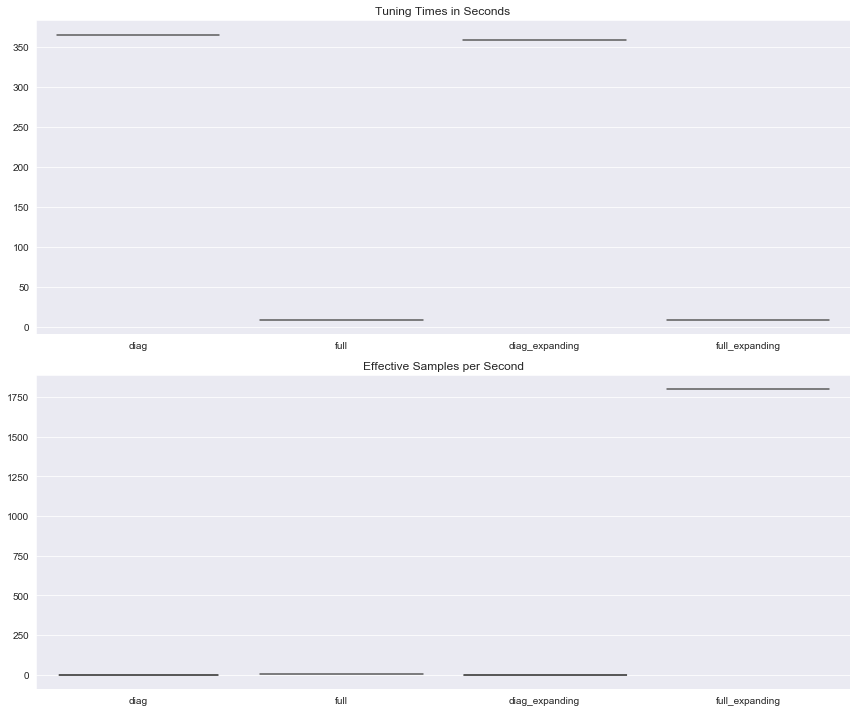

<IPython.core.display.Javascript object>

In [13]:
with open("mvnormal.json", "r") as f:
    dictionary = json.load(f)

tuning_times = dictionary["tuning_times"]
effective_samples_per_second = dictionary["effective_samples_per_second"]

compare_benchmark_results(tuning_times, effective_samples_per_second)
plot_benchmark_results(tuning_times, effective_samples_per_second)

Mean tuning times:
     covadapt
0  386.129172

Mean effective samples per second:
   covadapt
0  0.017006


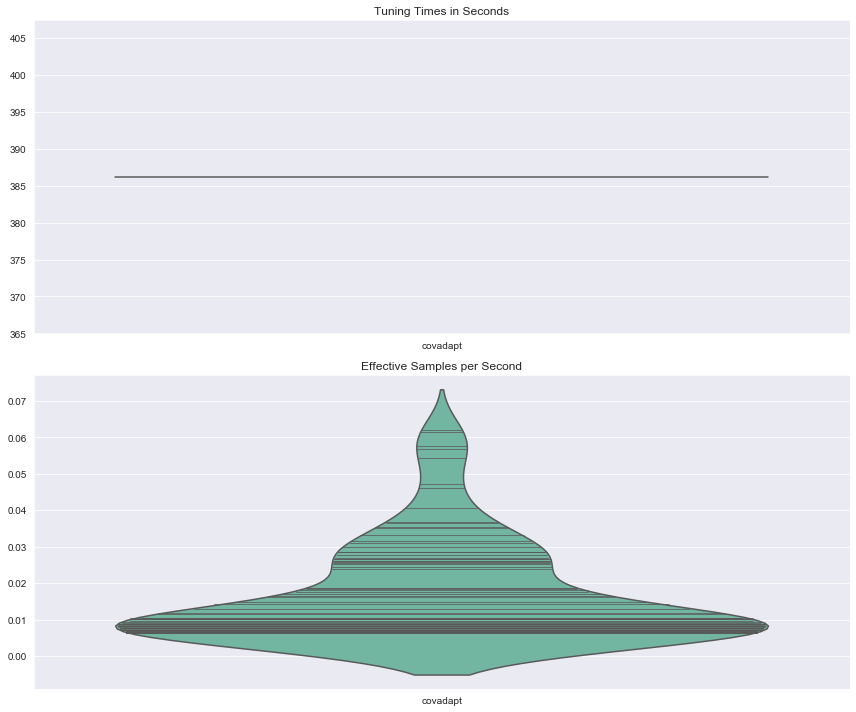

<IPython.core.display.Javascript object>

In [11]:
with open("mvnormal_covadapt.json", "r") as f:
    dictionary = json.load(f)

tuning_times = dictionary["tuning_times"]
effective_samples_per_second = dictionary["effective_samples_per_second"]

compare_benchmark_results(tuning_times, effective_samples_per_second)
plot_benchmark_results(tuning_times, effective_samples_per_second)

## Gaussian Process

In [9]:
# set the seed
np.random.seed(1)

n = 100  # The number of data points
X = np.linspace(0, 10, n)[
    :, None
]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

<IPython.core.display.Javascript object>

In [10]:
with pm.Model() as gp_model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

/Users/george/pymc3/pm-env/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


<IPython.core.display.Javascript object>

In [11]:
tuning_times, effective_samples_per_second = benchmark(gp_model, "gp")

diag


/Users/george/pymc3/pm-env/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/george/pymc3/pm-env/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/george/pymc3/pm-env/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future 

full


/Users/george/pymc3/pymc3/step_methods/hmc/quadpotential.py:481: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
/Users/george/pymc3/pm-env/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sampling chain 0, 0 divergences: 100%|█████████▉| 1995/2000 [00:14<00:00, 151.62it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:06<00:00, 155.72it/s]


diag_expanding


/Users/george/pymc3/pm-env/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sampling chain 0, 0 divergences: 100%|█████████▉| 1998/2000 [00:16<00:00, 128.82it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:07<00:00, 129.11it/s]


full_expanding


/Users/george/pymc3/pymc3/step_methods/hmc/quadpotential.py:481: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
/Users/george/pymc3/pm-env/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Sampling chain 0, 0 divergences: 100%|█████████▉| 1997/2000 [00:14<00:00, 163.04it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:06<00:00, 148.11it/s]


<IPython.core.display.Javascript object>

ndim =  3
Mean tuning times:
        diag       full  diag_expanding  full_expanding
0  18.469536  14.243434       16.253643       14.871327

Mean effective samples per second:
        diag        full  diag_expanding  full_expanding
0  65.361043  106.297068       59.890128      101.988949


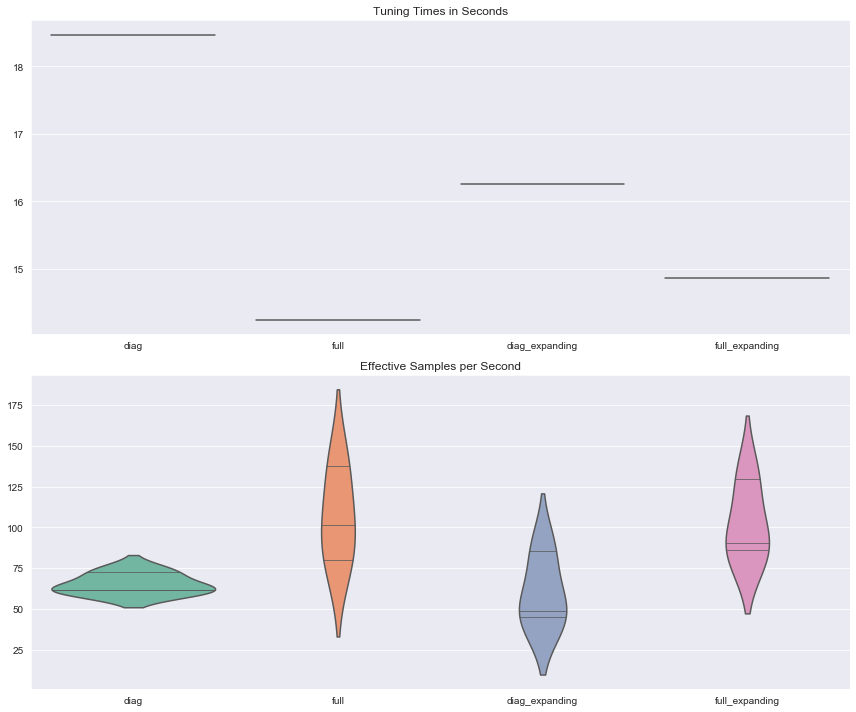

<IPython.core.display.Javascript object>

In [12]:
with open("gp.json", "r") as f:
    dictionary = json.load(f)

tuning_times = dictionary["tuning_times"]
effective_samples_per_second = dictionary["effective_samples_per_second"]

print("ndim = ", gp_model.ndim)
compare_benchmark_results(tuning_times, effective_samples_per_second)
plot_benchmark_results(tuning_times, effective_samples_per_second)

## Eight Schools

From https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html

In [13]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
tau = 25.0

with pm.Model() as eight_schools_model:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

<IPython.core.display.Javascript object>

In [14]:
tuning_times, effective_samples_per_second = benchmark(
    eight_schools_model, "eight_schools"
)

diag


Sampling chain 0, 0 divergences:  98%|█████████▊| 1959/2000 [00:02<00:00, 734.87it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:01<00:00, 778.04it/s]
/Users/george/pymc3/pymc3/step_methods/hmc/quadpotential.py:481: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")


full


Sampling chain 0, 0 divergences: 100%|█████████▉| 1994/2000 [00:02<00:00, 742.59it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:01<00:00, 828.61it/s]


diag_expanding


Sampling chain 0, 0 divergences:  98%|█████████▊| 1969/2000 [00:02<00:00, 680.70it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:01<00:00, 641.04it/s]
/Users/george/pymc3/pymc3/step_methods/hmc/quadpotential.py:481: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")


full_expanding


Sampling chain 0, 0 divergences:  98%|█████████▊| 1963/2000 [00:03<00:00, 696.08it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 1 divergences: 100%|██████████| 1000/1000 [00:01<00:00, 712.04it/s]


<IPython.core.display.Javascript object>

ndim =  10
Mean tuning times:
     diag      full  diag_expanding  full_expanding
0  2.9156  2.910612        3.049454        3.214669

Mean effective samples per second:
         diag        full  diag_expanding  full_expanding
0  761.815117  840.772086      640.901699      618.278954


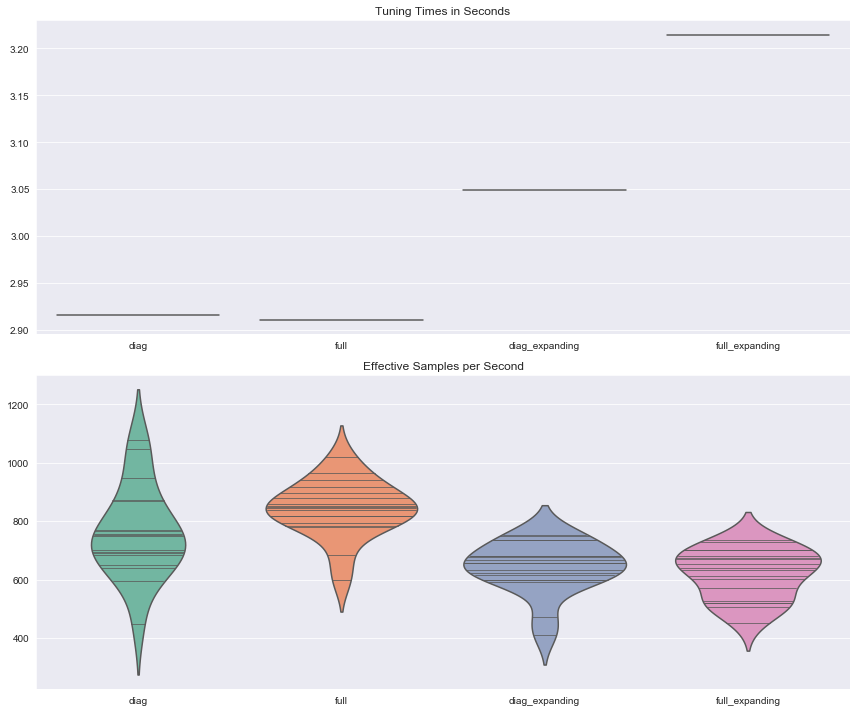

<IPython.core.display.Javascript object>

In [15]:
with open("eight_schools.json", "r") as f:
    dictionary = json.load(f)

tuning_times = dictionary["tuning_times"]
effective_samples_per_second = dictionary["effective_samples_per_second"]

print("ndim = ", eight_schools_model.ndim)
compare_benchmark_results(tuning_times, effective_samples_per_second)
plot_benchmark_results(tuning_times, effective_samples_per_second)

## Baseball

In [16]:
data = pd.read_csv(pm.get_data("efron-morris-75-data.tsv"), sep="\t")
at_bats, hits = data[["At-Bats", "Hits"]].values.T

N = len(hits)

with pm.Model() as baseball_model:
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)

    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

    thetas = pm.Beta("thetas", alpha=phi * kappa, beta=(1.0 - phi) * kappa, shape=N)
    y = pm.Binomial("y", n=at_bats, p=thetas, observed=hits)

<IPython.core.display.Javascript object>

In [17]:
tuning_times, effective_samples_per_second = benchmark(baseball_model, "baseball")

diag


Sampling chain 0, 0 divergences:  99%|█████████▉| 1987/2000 [00:05<00:00, 401.71it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:02<00:00, 427.63it/s]
/Users/george/pymc3/pymc3/step_methods/hmc/quadpotential.py:481: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")


full


Sampling chain 0, 0 divergences: 100%|█████████▉| 1996/2000 [00:04<00:00, 473.07it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:02<00:00, 395.65it/s]


diag_expanding


Sampling chain 0, 0 divergences:  98%|█████████▊| 1960/2000 [00:04<00:00, 411.22it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:02<00:00, 402.90it/s]
/Users/george/pymc3/pymc3/step_methods/hmc/quadpotential.py:481: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")


full_expanding


Sampling chain 0, 0 divergences:  98%|█████████▊| 1964/2000 [00:05<00:00, 363.32it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:02<00:00, 390.02it/s]


<IPython.core.display.Javascript object>

ndim =  20
Mean tuning times:
       diag      full  diag_expanding  full_expanding
0  5.322971  4.932806        5.084218        6.044468

Mean effective samples per second:
         diag        full  diag_expanding  full_expanding
0  455.234736  495.926603      336.708326      360.143776


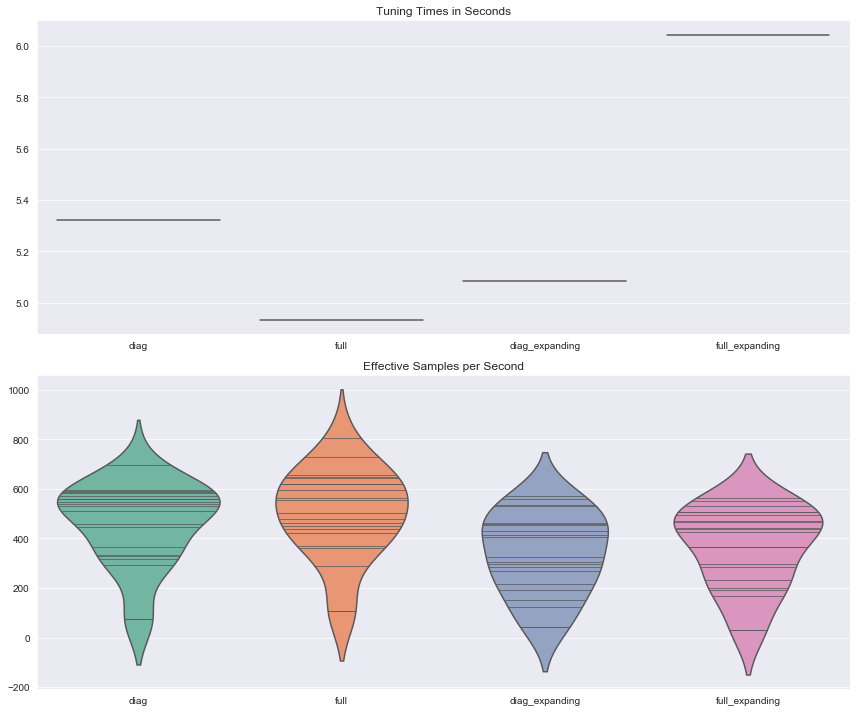

<IPython.core.display.Javascript object>

In [18]:
with open("baseball.json", "r") as f:
    dictionary = json.load(f)

tuning_times = dictionary["tuning_times"]
effective_samples_per_second = dictionary["effective_samples_per_second"]

print("ndim = ", baseball_model.ndim)
compare_benchmark_results(tuning_times, effective_samples_per_second)
plot_benchmark_results(tuning_times, effective_samples_per_second)

## Stochastic Volatility

In [12]:
rets = pd.read_csv(pm.get_data("SP500.csv"), index_col="Date")
rets["change"] = np.log(rets["Close"]).diff()
rets = rets.dropna()

with pm.Model() as stochastic_volatility_model:
    step_size = pm.Exponential("step_size", 10)
    volatility = pm.GaussianRandomWalk("volatility", sigma=step_size, shape=len(rets))
    nu = pm.Exponential("nu", 0.1)
    returns = pm.StudentT(
        "returns", nu=nu, lam=np.exp(-2 * volatility), observed=rets["change"]
    )

<IPython.core.display.Javascript object>

In [15]:
tuning_times, effective_samples_per_second = benchmark(
    stochastic_volatility_model, "stochastic_volatility"
)

diag


Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [03:59<00:00,  5.32it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [01:29<00:00, 11.21it/s]


full


/Users/george/pymc3/pymc3/step_methods/hmc/quadpotential.py:481: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [15:04<00:00,  4.37it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [02:45<00:00,  6.04it/s]


diag_expanding


Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [03:39<00:00,  6.59it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [01:35<00:00, 10.45it/s]


full_expanding


/Users/george/pymc3/pymc3/step_methods/hmc/quadpotential.py:481: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [11:26<00:00,  4.56it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [01:20<00:00, 12.47it/s]


<IPython.core.display.Javascript object>

In [13]:
tuning_times, effective_samples_per_second = benchmark(
    stochastic_volatility_model, "stochastic_volatility_covadapt", benchmark_covadapt=True
)

covadapt


Sampling chain 0, 0 divergences:  25%|██▌       | 500/2000 [01:37<02:45,  9.07it/s]

n_samples 300


Sampling chain 0, 0 divergences:  25%|██▌       | 502/2000 [01:38<04:51,  5.14it/s]

Finding eigenvalues took 0.36454296112060547s
eigvals [27.75508657 21.38675918 19.87910235 17.62972383 14.69901972 14.39731841
 13.20309193 12.30480358 10.80335137  9.9770435   8.33574589  7.841173
  7.18130393  6.63453491  5.727462    5.58940516  5.23433436  4.44598464
  3.73640727  3.50110585  0.14814271  0.1305476   0.12511745  0.10564718
  0.09839813  0.09433348  0.09101638  0.09006469  0.08031349  0.06919544
  0.06183304  0.05710725  0.05613797  0.05231681  0.04850216  0.04374129
  0.04224099  0.04182629  0.03519502  0.02851833]


Sampling chain 0, 0 divergences:  30%|███       | 600/2000 [01:59<05:36,  4.17it/s]

n_samples 300


Sampling chain 0, 0 divergences:  30%|███       | 601/2000 [01:59<08:08,  2.86it/s]

Finding eigenvalues took 0.35696887969970703s
eigvals [3.83802691e+01 2.23597016e+01 1.93783267e+01 1.62610216e+01
 1.53682114e+01 1.41068948e+01 1.31933167e+01 1.24873667e+01
 1.14344618e+01 1.10233246e+01 9.64503269e+00 9.07953089e+00
 8.39731151e+00 7.78815991e+00 6.64467227e+00 6.01595120e+00
 5.15264327e+00 4.69029561e+00 4.04190246e+00 3.96437879e+00
 1.55252737e-01 1.34323620e-01 1.25987021e-01 1.14618415e-01
 1.05750485e-01 1.00785338e-01 9.75816698e-02 9.10234505e-02
 8.18490830e-02 7.67782549e-02 7.56885457e-02 6.72528803e-02
 6.46200991e-02 6.01559673e-02 4.86913214e-02 4.58829635e-02
 4.32374802e-02 3.96790361e-02 3.68174874e-02 3.16952576e-02]


Sampling chain 0, 0 divergences:  35%|███▌      | 700/2000 [02:26<06:45,  3.21it/s]

n_samples 300


Sampling chain 0, 0 divergences:  35%|███▌      | 701/2000 [02:26<09:55,  2.18it/s]

Finding eigenvalues took 0.5350399017333984s
eigvals [4.51069009e+01 2.31740853e+01 2.11163299e+01 1.87359773e+01
 1.69918201e+01 1.61808369e+01 1.43847351e+01 1.19781427e+01
 1.19112711e+01 1.08413805e+01 9.85011003e+00 9.59597678e+00
 7.75289529e+00 7.25465670e+00 6.84230155e+00 6.54069763e+00
 6.15358162e+00 5.06825597e+00 4.70296554e+00 3.16060540e+00
 1.93569805e-01 1.27194711e-01 1.07219992e-01 1.00520162e-01
 9.67798533e-02 8.97104784e-02 8.39624085e-02 7.57683905e-02
 7.06659076e-02 6.70444269e-02 6.28586045e-02 5.60081059e-02
 5.22515002e-02 4.76678865e-02 4.27732011e-02 3.93764303e-02
 3.48350085e-02 3.25451749e-02 2.82719240e-02 2.43343283e-02]


Sampling chain 0, 0 divergences:  40%|████      | 800/2000 [02:49<05:16,  3.79it/s]

n_samples 300


Sampling chain 0, 0 divergences:  40%|████      | 802/2000 [02:50<06:07,  3.26it/s]

Finding eigenvalues took 0.35219788551330566s
eigvals [4.66326284e+01 2.57063999e+01 2.05483842e+01 2.02131222e+01
 1.81317727e+01 1.57423302e+01 1.47226574e+01 1.33887827e+01
 1.29712383e+01 1.12778542e+01 1.02431542e+01 9.66407315e+00
 8.52293225e+00 7.63890306e+00 7.25009381e+00 6.46911706e+00
 6.13217016e+00 5.19772913e+00 4.81847377e+00 3.95967283e+00
 1.62759886e-01 1.48887990e-01 1.29544678e-01 1.19332272e-01
 1.08164945e-01 1.02242916e-01 9.41430194e-02 8.81800907e-02
 8.07514151e-02 7.53917981e-02 7.21604676e-02 6.33745513e-02
 6.08833112e-02 5.86902764e-02 5.30815794e-02 4.99929573e-02
 4.89942700e-02 4.27962446e-02 3.68797606e-02 3.22912317e-02]


Sampling chain 0, 0 divergences:  45%|████▌     | 900/2000 [03:10<02:52,  6.37it/s]

n_samples 300


Sampling chain 0, 0 divergences:  45%|████▌     | 902/2000 [03:10<04:01,  4.55it/s]

Finding eigenvalues took 0.3523409366607666s
eigvals [4.78909810e+01 2.54902614e+01 2.40027691e+01 1.79130456e+01
 1.57170256e+01 1.49674476e+01 1.37787773e+01 1.35430014e+01
 1.24172721e+01 1.18741121e+01 1.10773643e+01 9.99765513e+00
 9.03370583e+00 8.78229701e+00 7.80656305e+00 7.27091936e+00
 6.51984887e+00 5.92214820e+00 5.04335201e+00 4.77921649e+00
 1.77855693e-01 1.53347266e-01 1.36801982e-01 1.26038688e-01
 1.16360020e-01 1.10722869e-01 1.04498534e-01 9.65757613e-02
 9.17091133e-02 8.14602924e-02 7.36107502e-02 7.09287634e-02
 6.55107805e-02 5.71479365e-02 5.26681074e-02 4.70259497e-02
 4.12818105e-02 3.85458833e-02 3.61821294e-02 3.13140493e-02]


Sampling chain 0, 0 divergences:  50%|█████     | 1000/2000 [03:28<03:25,  4.87it/s]

n_samples 300


Sampling chain 0, 0 divergences:  50%|█████     | 1002/2000 [03:29<04:41,  3.54it/s]

Finding eigenvalues took 0.37482118606567383s
eigvals [3.71292175e+01 2.55214182e+01 2.25936255e+01 1.98824435e+01
 1.81575752e+01 1.65090780e+01 1.45133611e+01 1.30074066e+01
 1.22826044e+01 1.05367066e+01 1.03326535e+01 9.92948011e+00
 8.99533511e+00 8.11321834e+00 7.15158888e+00 6.66427266e+00
 5.98290485e+00 5.31568187e+00 4.36780031e+00 3.49904110e+00
 1.96838028e-01 1.38761573e-01 1.28718358e-01 1.23694425e-01
 1.15502424e-01 1.13830032e-01 1.04790003e-01 9.44557802e-02
 8.54961271e-02 7.96226914e-02 7.58603222e-02 7.30841759e-02
 6.42714136e-02 6.05932436e-02 5.91522376e-02 5.34508071e-02
 4.74546048e-02 4.44527844e-02 4.01151240e-02 3.69743540e-02]


Sampling chain 0, 0 divergences:  55%|█████▌    | 1100/2000 [03:47<02:54,  5.16it/s]

n_samples 300


Sampling chain 0, 0 divergences:  55%|█████▌    | 1101/2000 [03:47<04:40,  3.21it/s]

Finding eigenvalues took 0.4316391944885254s
eigvals [4.17947907e+01 2.51312952e+01 1.97581126e+01 1.80426001e+01
 1.56768296e+01 1.50537160e+01 1.24817027e+01 1.21077596e+01
 1.14906868e+01 1.05819633e+01 1.00208431e+01 9.65279785e+00
 8.80557911e+00 7.03457957e+00 6.64813677e+00 6.32802714e+00
 5.78309447e+00 4.62623754e+00 4.04141602e+00 3.80414680e+00
 1.61419508e-01 1.44682138e-01 1.30530806e-01 1.22701640e-01
 1.15970623e-01 1.04126126e-01 9.55102174e-02 9.09743242e-02
 8.76784310e-02 8.03824669e-02 7.47859742e-02 6.71903043e-02
 6.24657073e-02 6.07230165e-02 5.46726707e-02 5.28381191e-02
 4.84607577e-02 4.50127998e-02 3.84814587e-02 3.08740883e-02]


Sampling chain 0, 0 divergences:  60%|██████    | 1200/2000 [04:04<01:50,  7.25it/s]

n_samples 300


Sampling chain 0, 0 divergences:  60%|██████    | 1202/2000 [04:05<02:56,  4.52it/s]

Finding eigenvalues took 0.3725860118865967s
eigvals [3.38345671e+01 2.48137270e+01 2.17018323e+01 1.79053573e+01
 1.59649431e+01 1.43441797e+01 1.25336325e+01 1.19220697e+01
 1.03741663e+01 9.98077752e+00 9.06654085e+00 8.44023250e+00
 8.25710183e+00 7.86781591e+00 6.96129748e+00 5.84041337e+00
 5.15323032e+00 4.68460721e+00 4.19423454e+00 3.68940248e+00
 1.74403398e-01 1.53873836e-01 1.41780149e-01 1.31534008e-01
 1.20736195e-01 1.12412338e-01 1.09754731e-01 9.75842196e-02
 8.80922489e-02 8.38943087e-02 7.72224212e-02 6.82081358e-02
 6.52065849e-02 6.36538285e-02 5.91487599e-02 5.73203980e-02
 5.15045316e-02 4.34145767e-02 4.09587900e-02 3.29621036e-02]


Sampling chain 0, 0 divergences:  65%|██████▌   | 1300/2000 [04:22<02:32,  4.60it/s]

n_samples 300


Sampling chain 0, 0 divergences:  65%|██████▌   | 1301/2000 [04:23<03:34,  3.25it/s]

Finding eigenvalues took 0.3642401695251465s
eigvals [3.96134036e+01 2.28198793e+01 1.83883016e+01 1.68343492e+01
 1.53589004e+01 1.37546624e+01 1.23671355e+01 1.12729152e+01
 9.92832107e+00 9.53390151e+00 8.82247784e+00 8.54331805e+00
 8.29484419e+00 7.65818694e+00 6.27067309e+00 5.95048461e+00
 5.70794968e+00 5.09430700e+00 4.91847891e+00 3.85278961e+00
 1.77629648e-01 1.48321340e-01 1.31526421e-01 1.24806032e-01
 1.19015336e-01 1.02574871e-01 9.80412182e-02 8.60356066e-02
 7.89262073e-02 7.80327912e-02 7.23083621e-02 6.24027989e-02
 5.77961255e-02 5.53173074e-02 4.98118588e-02 4.76270967e-02
 4.17385914e-02 3.93520489e-02 3.42170095e-02 2.78104015e-02]


Sampling chain 0, 0 divergences:  70%|███████   | 1400/2000 [04:47<02:38,  3.78it/s]

n_samples 300


Sampling chain 0, 0 divergences:  70%|███████   | 1402/2000 [04:48<03:11,  3.12it/s]

Finding eigenvalues took 0.369279146194458s
eigvals [3.25726632e+01 2.14375034e+01 1.82673250e+01 1.71681503e+01
 1.58427189e+01 1.48035048e+01 1.33785307e+01 1.14665390e+01
 1.13855193e+01 9.47911091e+00 8.88987504e+00 8.50497989e+00
 7.98662271e+00 7.23268305e+00 6.39984671e+00 6.29761820e+00
 5.57084004e+00 5.23157937e+00 4.76542124e+00 3.61286917e+00
 1.49302194e-01 1.23348666e-01 1.10136686e-01 1.08535123e-01
 1.01213481e-01 8.93218213e-02 8.55710603e-02 7.74243278e-02
 7.53840642e-02 7.08832474e-02 6.54999801e-02 5.80228070e-02
 5.59194871e-02 5.06153423e-02 4.53108077e-02 4.38560972e-02
 3.97803848e-02 3.43691213e-02 3.16311096e-02 2.87457641e-02]


Sampling chain 0, 0 divergences:  75%|███████▌  | 1500/2000 [05:04<01:58,  4.24it/s]

n_samples 300


Sampling chain 0, 0 divergences:  75%|███████▌  | 1502/2000 [05:04<02:26,  3.39it/s]

Finding eigenvalues took 0.36118102073669434s
eigvals [3.47504128e+01 2.27592954e+01 1.95784714e+01 1.86055407e+01
 1.63743972e+01 1.48458229e+01 1.35361380e+01 1.29476400e+01
 1.15134958e+01 1.03570165e+01 9.76573787e+00 9.18622598e+00
 8.36673709e+00 7.97202516e+00 7.43392409e+00 6.78257568e+00
 6.00297245e+00 5.17336277e+00 4.80890059e+00 4.06306231e+00
 1.95984742e-01 1.48184725e-01 1.43476780e-01 1.27605964e-01
 1.17921785e-01 1.10321430e-01 1.01537623e-01 9.27914561e-02
 9.04684314e-02 8.63480019e-02 7.42813945e-02 7.09821816e-02
 6.49425329e-02 6.11519257e-02 5.98633981e-02 4.96042716e-02
 4.70915850e-02 4.14610636e-02 3.94208604e-02 2.89825586e-02]


Sampling chain 0, 0 divergences:  80%|████████  | 1600/2000 [05:20<01:34,  4.22it/s]

n_samples 300


Sampling chain 0, 0 divergences:  80%|████████  | 1601/2000 [05:21<02:05,  3.18it/s]

Finding eigenvalues took 0.35254406929016113s
eigvals [3.05891722e+01 2.15155777e+01 2.01961477e+01 1.79641135e+01
 1.62063439e+01 1.52746976e+01 1.29839792e+01 1.22513779e+01
 1.17095029e+01 1.04429878e+01 9.92971708e+00 9.69710274e+00
 7.98257524e+00 7.60798165e+00 7.17876850e+00 6.37115249e+00
 5.82136255e+00 4.93550497e+00 4.83985129e+00 3.55050453e+00
 1.84137154e-01 1.46141858e-01 1.31646865e-01 1.24892788e-01
 1.12818178e-01 1.10017291e-01 9.72239426e-02 9.61201387e-02
 9.32435767e-02 8.15874235e-02 7.63157499e-02 5.93710296e-02
 5.67140678e-02 5.18810688e-02 5.02081116e-02 4.79424110e-02
 4.33130230e-02 3.97268431e-02 3.37048438e-02 2.52187080e-02]


Sampling chain 0, 0 divergences:  85%|████████▌ | 1700/2000 [05:40<01:03,  4.69it/s]

n_samples 300


Sampling chain 0, 0 divergences:  85%|████████▌ | 1701/2000 [05:41<01:40,  2.98it/s]

Finding eigenvalues took 0.3512539863586426s
eigvals [4.06889352e+01 2.18907513e+01 1.94911437e+01 1.92526246e+01
 1.71808222e+01 1.53214021e+01 1.35280903e+01 1.25075567e+01
 1.19621755e+01 1.08001291e+01 1.01541636e+01 9.63246168e+00
 8.20204257e+00 7.62229227e+00 7.14956275e+00 6.11345632e+00
 5.88653923e+00 4.39431674e+00 3.99720168e+00 3.07373304e+00
 1.47780012e-01 1.11802380e-01 9.84334205e-02 9.34602211e-02
 8.71872446e-02 8.22150271e-02 7.99828172e-02 7.11406550e-02
 6.64778523e-02 6.18120043e-02 5.56171150e-02 5.08559012e-02
 4.52428457e-02 4.30775513e-02 4.03562283e-02 3.79457714e-02
 3.36956794e-02 3.12343385e-02 2.82103414e-02 2.40959405e-02]


Sampling chain 0, 0 divergences:  90%|█████████ | 1800/2000 [06:04<00:50,  3.96it/s]

n_samples 300


Sampling chain 0, 0 divergences:  90%|█████████ | 1801/2000 [06:05<01:11,  2.79it/s]

Finding eigenvalues took 0.34151506423950195s
eigvals [4.56418651e+01 2.78480696e+01 2.20763858e+01 1.94136035e+01
 1.85506280e+01 1.67458055e+01 1.44224036e+01 1.25629839e+01
 1.17983495e+01 1.13773563e+01 1.01667786e+01 9.96361708e+00
 8.64409752e+00 8.28483145e+00 6.79694504e+00 6.40190232e+00
 6.13489085e+00 5.92759555e+00 4.53271740e+00 4.49650531e+00
 1.35099343e-01 1.17115718e-01 9.45472723e-02 9.00019117e-02
 8.27693957e-02 8.16768417e-02 7.93730802e-02 7.29635039e-02
 6.67069172e-02 5.94930222e-02 5.46580453e-02 5.11872817e-02
 4.91554297e-02 4.69980294e-02 4.41187195e-02 4.01192676e-02
 3.82897415e-02 3.48020364e-02 3.01904313e-02 2.63128851e-02]


Sampling chain 0, 0 divergences:  95%|█████████▌| 1900/2000 [06:23<00:14,  7.04it/s]

n_samples 300


Sampling chain 0, 0 divergences:  95%|█████████▌| 1902/2000 [06:23<00:21,  4.57it/s]

Finding eigenvalues took 0.34589576721191406s
eigvals [3.99623509e+01 2.88121658e+01 2.30919320e+01 2.14565166e+01
 1.79973203e+01 1.51737108e+01 1.42847121e+01 1.37893569e+01
 1.34027146e+01 1.18463506e+01 1.10315938e+01 9.83248642e+00
 8.69426940e+00 8.28383734e+00 7.76178680e+00 7.26939550e+00
 6.48199902e+00 6.03009812e+00 5.51873085e+00 4.40082988e+00
 1.58064500e-01 1.37042486e-01 1.31054646e-01 1.16165756e-01
 1.11138974e-01 1.01159862e-01 9.29996617e-02 8.69305441e-02
 8.31765226e-02 7.73969856e-02 7.12846010e-02 6.46280044e-02
 5.77861529e-02 5.49073072e-02 5.09439300e-02 4.93321527e-02
 4.79267051e-02 4.04826035e-02 3.89925171e-02 3.39937113e-02]


Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [06:38<00:00,  7.27it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [02:40<00:00,  6.23it/s]


<IPython.core.display.Javascript object>

Mean tuning times:
         diag        full  diag_expanding  full_expanding
0  239.594109  904.952251      219.649739      686.576914

Mean effective samples per second:
        diag      full  diag_expanding  full_expanding
0  11.221393  6.709438        9.792237        0.159799


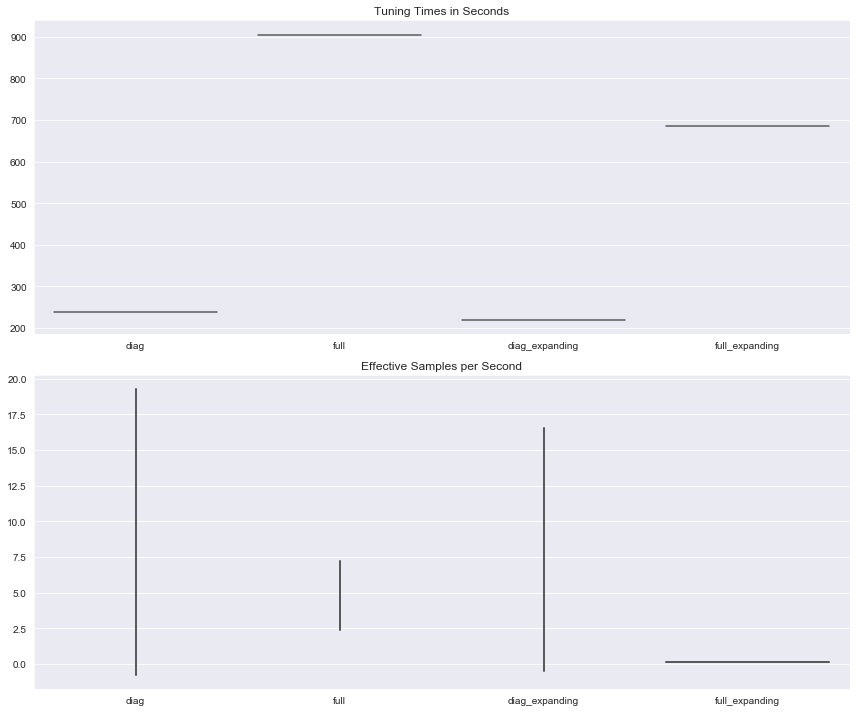

<IPython.core.display.Javascript object>

In [16]:
with open("stochastic_volatility.json", "r") as f:
    dictionary = json.load(f)

tuning_times = dictionary["tuning_times"]
effective_samples_per_second = dictionary["effective_samples_per_second"]

compare_benchmark_results(tuning_times, effective_samples_per_second)
plot_benchmark_results(tuning_times, effective_samples_per_second)

Mean tuning times:
     covadapt
0  398.082031

Mean effective samples per second:
   covadapt
0  5.707952


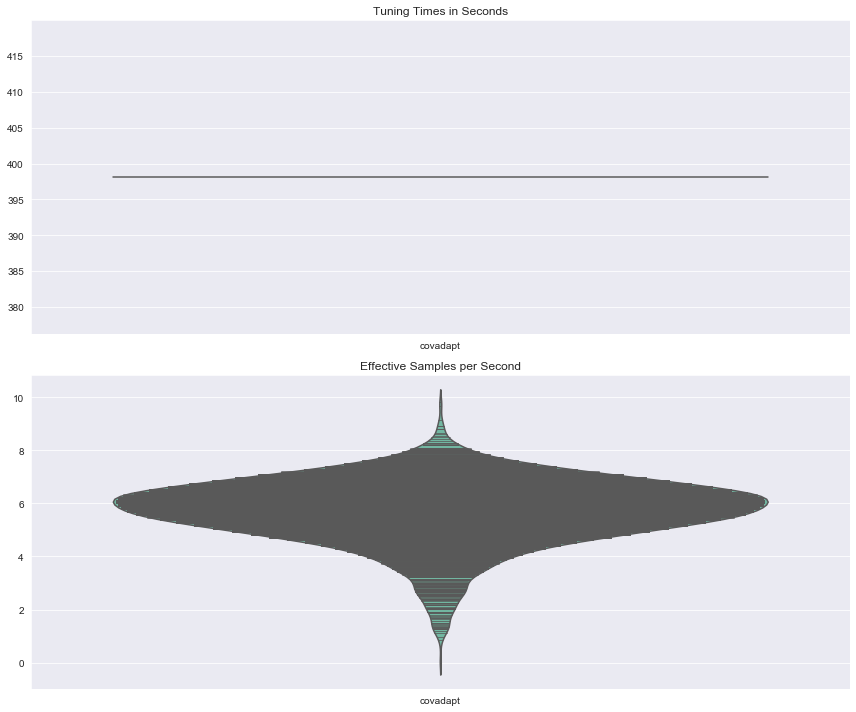

<IPython.core.display.Javascript object>

In [14]:
with open("stochastic_volatility_covadapt.json", "r") as f:
    dictionary = json.load(f)

tuning_times = dictionary["tuning_times"]
effective_samples_per_second = dictionary["effective_samples_per_second"]

compare_benchmark_results(tuning_times, effective_samples_per_second)
plot_benchmark_results(tuning_times, effective_samples_per_second)

## Low-Rank Multivariate Normal

In [7]:
n = 100

U = np.array(
    [[1, 0, -3, 0, 0, 6] + [0] * (n - 6), [0, 5, 0, 3, -2, 0] + [0] * (n - 6)]
).T

U = U / np.sqrt((U ** 2).sum(0))[None, :]
sigma = np.diag([2000000, 0.00001])
cov = U @ sigma @ U.T + (np.eye(n) - U @ U.T)

with pm.Model() as lowrank_mvnormal_model:
    pm.MvNormal("a", shape=n, mu=0, cov=cov)

<IPython.core.display.Javascript object>

In [8]:
tuning_times, effective_samples_per_second = benchmark(
    lowrank_mvnormal_model, "lowrank_mvnormal"
)

diag


Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [05:40<00:00,  5.42it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [03:07<00:00,  5.35it/s]
/Users/george/pymc3/pymc3/step_methods/hmc/quadpotential.py:481: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sampling chain 0, 0 divergences:   0%|          | 0/2000 [00:00<?, ?it/s]

full


Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [06:04<00:00,  4.43it/s] /Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences:   0%|          | 0/2000 [00:00<?, ?it/s]

diag_expanding


Sampling chain 0, 0 divergences: 100%|██████████| 2000/2000 [06:00<00:00,  4.58it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [03:19<00:00,  5.03it/s]
/Users/george/pymc3/pymc3/step_methods/hmc/quadpotential.py:481: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sampling chain 0, 0 divergences:   0%|          | 0/2000 [00:00<?, ?it/s]

full_expanding


Sampling chain 0, 0 divergences:  99%|█████████▉| 1977/2000 [02:22<00:00, 75.10it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:00<00:00, 1786.48it/s]


<IPython.core.display.Javascript object>

In [10]:
tuning_times, effective_samples_per_second = benchmark(
    lowrank_mvnormal_model, "lowrank_mvnormal_covadapt", benchmark_covadapt=True
)

covadapt


Sampling chain 0, 0 divergences:  25%|██▌       | 501/2000 [01:19<06:01,  4.15it/s]

n_samples 300
Finding eigenvalues took 0.02222418785095215s
eigvals [7.05105628e-05 2.95703975e-05 7.88416403e-06]


Sampling chain 0, 0 divergences:  31%|███▏      | 629/2000 [01:24<00:17, 76.28it/s]

n_samples 300
Finding eigenvalues took 0.014288902282714844s
eigvals [2.75839694e+00 3.82172726e-05 2.90948257e-05 2.10066542e-06]


Sampling chain 0, 0 divergences:  37%|███▋      | 731/2000 [01:25<00:07, 161.83it/s]

n_samples 300
Finding eigenvalues took 0.014165163040161133s
eigvals [3.44578661e-05 2.53368664e-05 2.96870142e-06]


Sampling chain 0, 0 divergences:  42%|████▏     | 833/2000 [01:25<00:05, 221.28it/s]

n_samples 300
Finding eigenvalues took 0.013447284698486328s
eigvals [2.45974286e+00 3.07265845e-05 2.36754061e-05 3.15128214e-06]


Sampling chain 0, 0 divergences:  47%|████▋     | 942/2000 [01:25<00:04, 253.26it/s]

n_samples 300
Finding eigenvalues took 0.013941049575805664s
eigvals [2.14194797e+00 3.94235192e-05 2.08854931e-05 2.73708890e-06]


Sampling chain 0, 0 divergences:  51%|█████▏    | 1028/2000 [01:26<00:03, 268.06it/s]

n_samples 300
Finding eigenvalues took 0.013408184051513672s
eigvals [2.83001286e+00 5.45710261e-05 3.54089468e-05 2.82639502e-06]


Sampling chain 0, 0 divergences:  57%|█████▋    | 1139/2000 [01:26<00:03, 254.72it/s]

n_samples 300
Finding eigenvalues took 0.013936042785644531s
eigvals [2.59127526e+00 5.46076693e-05 3.47819658e-05 2.69262698e-06]


Sampling chain 0, 0 divergences:  62%|██████▏   | 1241/2000 [01:27<00:03, 233.28it/s]

n_samples 300
Finding eigenvalues took 0.014275789260864258s
eigvals [2.63191462e+00 4.00070036e-05 2.99129124e-05 2.53409652e-06]


Sampling chain 0, 0 divergences:  66%|██████▋   | 1327/2000 [01:27<00:02, 254.95it/s]

n_samples 300
Finding eigenvalues took 0.013605833053588867s
eigvals [2.63538566e+00 2.96534518e-05 2.40420541e-05 3.62294968e-06]


Sampling chain 0, 0 divergences:  72%|███████▏  | 1438/2000 [01:27<00:02, 258.94it/s]

n_samples 300
Finding eigenvalues took 0.014986038208007812s
eigvals [2.16941534e+00 2.85453138e-05 2.47319313e-05 3.75785956e-06]


Sampling chain 0, 0 divergences:  77%|███████▋  | 1547/2000 [01:28<00:01, 244.61it/s]

n_samples 300
Finding eigenvalues took 0.016858816146850586s
eigvals [2.27034082e+00 3.81536141e-05 1.93751885e-05 2.94832141e-06]


Sampling chain 0, 0 divergences:  82%|████████▏ | 1630/2000 [01:28<00:01, 258.12it/s]

n_samples 300
Finding eigenvalues took 0.014373779296875s
eigvals [2.29128750e+00 4.33965900e-05 2.19045171e-05 1.75825952e-06]


Sampling chain 0, 0 divergences:  88%|████████▊ | 1750/2000 [01:28<00:00, 286.36it/s]

n_samples 300
Finding eigenvalues took 0.013770818710327148s
eigvals [2.18307425e+00 3.32266010e-05 2.08378610e-05 2.11985615e-06]


Sampling chain 0, 0 divergences:  92%|█████████▏| 1840/2000 [01:29<00:00, 275.18it/s]

n_samples 300
Finding eigenvalues took 0.013689994812011719s
eigvals [2.85736365e+00 3.44392687e-05 2.55528103e-05 2.95609947e-06]


Sampling chain 0, 0 divergences:  96%|█████████▋| 1926/2000 [01:29<00:00, 268.81it/s]

n_samples 300
Finding eigenvalues took 0.014532089233398438s
eigvals [2.93324624e+00 3.32999010e-05 2.32800199e-05 2.62951620e-06]


Sampling chain 0, 0 divergences:  99%|█████████▉| 1986/2000 [01:29<00:00, 279.90it/s]/Users/george/pymc3/pm-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences: 100%|██████████| 1000/1000 [00:03<00:00, 288.70it/s]


<IPython.core.display.Javascript object>

Mean tuning times:
         diag        full  diag_expanding  full_expanding
0  340.103114  364.071076      360.906868      142.196813

Mean effective samples per second:
       diag      full  diag_expanding  full_expanding
0  1.545693  0.006081        1.505607     1753.653389


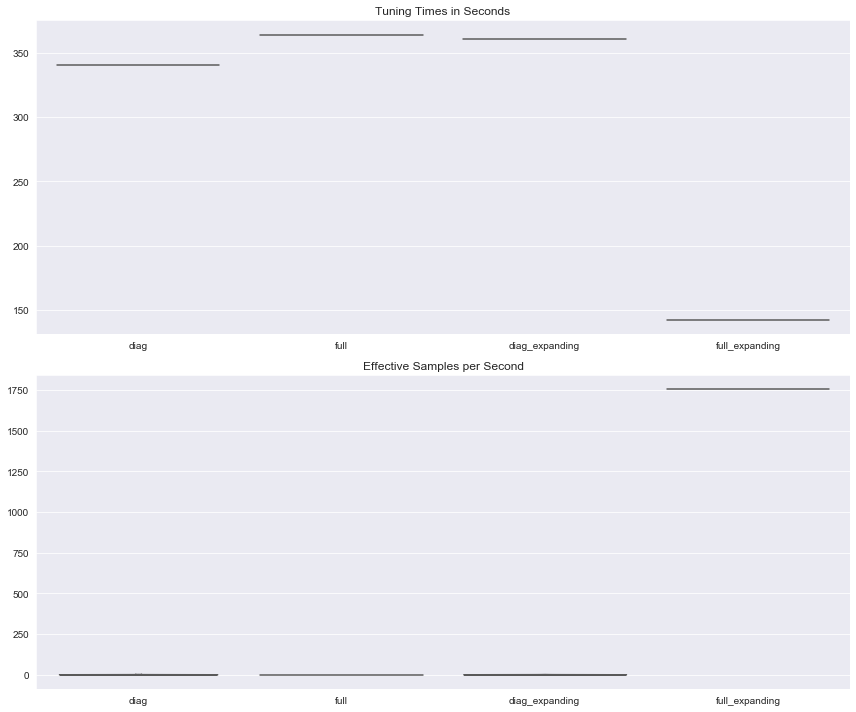

<IPython.core.display.Javascript object>

In [9]:
with open("lowrank_mvnormal.json", "r") as f:
    dictionary = json.load(f)

tuning_times = dictionary["tuning_times"]
effective_samples_per_second = dictionary["effective_samples_per_second"]

compare_benchmark_results(tuning_times, effective_samples_per_second)
plot_benchmark_results(tuning_times, effective_samples_per_second)

Mean tuning times:
    covadapt
0  89.921496

Mean effective samples per second:
     covadapt
0  693.867379


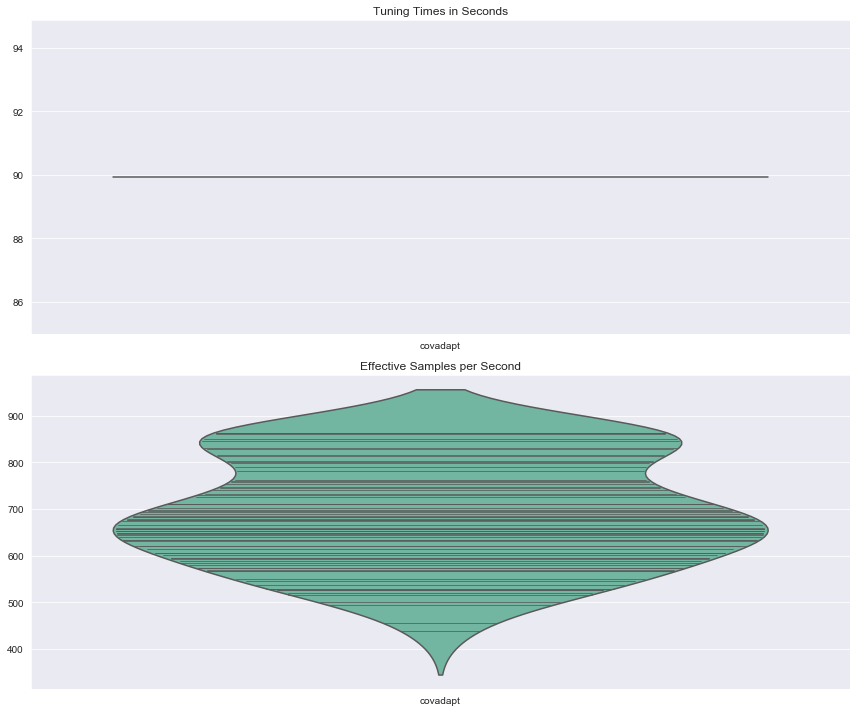

<IPython.core.display.Javascript object>

In [11]:
with open("lowrank_mvnormal_covadapt.json", "r") as f:
    dictionary = json.load(f)

tuning_times = dictionary["tuning_times"]
effective_samples_per_second = dictionary["effective_samples_per_second"]

compare_benchmark_results(tuning_times, effective_samples_per_second)
plot_benchmark_results(tuning_times, effective_samples_per_second)

## Computing Environment

In [2]:
!conda list --export

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: osx-64
alabaster=0.7.12=pypi_0
appdirs=1.4.3=pypi_0
appnope=0.1.0=pypi_0
argh=0.26.2=pypi_0
arviz=0.5.1=pypi_0
astroid=2.3.3=pypi_0
attrs=19.3.0=pypi_0
babel=2.7.0=pypi_0
backcall=0.1.0=pypi_0
black=19.10b0=pypi_0
bleach=3.1.0=pypi_0
bokeh=1.4.0=pypi_0
ca-certificates=2019.11.27=0
certifi=2019.11.28=py36_0
cftime=1.0.4.2=pypi_0
chardet=3.0.4=pypi_0
click=7.0=pypi_0
commonmark=0.9.1=pypi_0
covadapt=0.1=pypi_0
coverage=4.5.4=pypi_0
cycler=0.10.0=pypi_0
decorator=4.4.1=pypi_0
defusedxml=0.6.0=pypi_0
docutils=0.15.2=pypi_0
entrypoints=0.3=pypi_0
h5py=2.10.0=pypi_0
idna=2.8=pypi_0
imagesize=1.1.0=pypi_0
importlib-metadata=1.1.0=pypi_0
intel-openmp=2019.4=233
ipykernel=5.1.3=pypi_0
ipython=7.10.1=pypi_0
ipython-genutils=0.2.0=pypi_0
ipywidgets=7.5.1=pypi_0
isort=4.3.21=pypi_0
jedi=0.15.1=pypi_0
jinja2=2.10.3=pypi_0
joblib=0.14.0=pypi_0
jsonschema=3.2.0=pypi_0
jupyter=1.0.0=pyp